# Importing

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as model
import torch.optim as optim
import copy
import zipfile


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Loading Dataset

In [4]:
!unzip "./drive/My Drive/finger/SocoFing_data(alter_real_and_gender_train_test).zip" -d "./data" 

Streaming output truncated to the last 5000 lines.
  inflating: ./data/SocoFing_data(alter_real_and_gender_train_test)/finger_data_altered_real_train/Altered/easy17854.BMP  
  inflating: ./data/SocoFing_data(alter_real_and_gender_train_test)/finger_data_altered_real_train/Altered/156__F_Left_ring_finger_Obl.BMP  
  inflating: ./data/SocoFing_data(alter_real_and_gender_train_test)/finger_data_altered_real_train/Altered/348__F_Right_thumb_finger_Obl.BMP  
  inflating: ./data/SocoFing_data(alter_real_and_gender_train_test)/finger_data_altered_real_train/Altered/412__M_Left_index_finger_Zcut.BMP  
  inflating: ./data/SocoFing_data(alter_real_and_gender_train_test)/finger_data_altered_real_train/Altered/581__F_Left_thumb_finger_Zcut.BMP  
  inflating: ./data/SocoFing_data(alter_real_and_gender_train_test)/finger_data_altered_real_train/Altered/556__F_Right_little_finger_Obl.BMP  
  inflating: ./data/SocoFing_data(alter_real_and_gender_train_test)/finger_data_altered_real_train/Altered/easy1

In [42]:
transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [43]:
trainset = torchvision.datasets.ImageFolder('./data/SocoFing_data(alter_real_and_gender_train_test)/finger_gender_data_train',transform=transform)
testset = torchvision.datasets.ImageFolder('./data/SocoFing_data(alter_real_and_gender_train_test)/finger_gender_data_test',transform = transform)

In [44]:
trainset.class_to_idx

{'female': 0, 'male': 1}

In [45]:
testset.class_to_idx

{'female': 0, 'male': 1}

In [46]:
torch.unique(torch.tensor(trainset.targets), return_counts=True)

(tensor([0, 1]), tensor([1722, 1500]))

In [47]:
torch.unique(torch.tensor(testset.targets), return_counts=True)

(tensor([0, 1]), tensor([517, 517]))

In [ ]:
!ls -a './data/SocoFing_data(alter_real_and_gender_train_test)/finger_data_alter_real_test'

.  ..  Altered	Real


In [ ]:
!rm -r './data/SocoFing_data(alter_real_and_gender_train_test)/finger_data_alter_real_test/.ipynb_checkpoints'

In [15]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size = 32,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size = 32,shuffle=False)

# Architectures

## Inception_v3 Architecture

In [48]:
inception = model.inception_v3(pretrained= True)
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [49]:
for param in inception.parameters():
  param.requires_grad = False

In [50]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, 2)

In [51]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([2, 768])
torch.Size([2])


In [52]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, 2)

In [53]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([2, 768])
torch.Size([2])
torch.Size([2, 2048])
torch.Size([2])


In [54]:
for param in inception.Conv2d_1a_3x3.parameters():
  param.requires_grad = True
for param in inception.Conv2d_2a_3x3.parameters():
  param.requires_grad = True

In [55]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([2, 768])
torch.Size([2])
torch.Size([2, 2048])
torch.Size([2])


In [56]:
def evaluation_inception(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, aux_outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [57]:
inception = inception.to(device)
#manual_weights = [0.5,5]
#manual_weights = torch.FloatTensor(manual_weights).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(inception.parameters(), lr=0.0001)
trainloader = torch.utils.data.DataLoader(trainset,batch_size = 32,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size = 32,shuffle=False)


Min loss 0.94
Iteration: 0, Loss: 0.94
Min loss 0.94
Min loss 0.94
Min loss 0.91
Min loss 0.90
Min loss 0.87
Min loss 0.87
Min loss 0.86
Min loss 0.80
Min loss 0.79
Epoch: 0/20, Test acc: 48.26, Train acc: 59.09
Iteration: 0, Loss: 0.91
Min loss 0.77
Min loss 0.76
Min loss 0.74
Min loss 0.73
Epoch: 1/20, Test acc: 49.13, Train acc: 61.42
Iteration: 0, Loss: 0.96
Min loss 0.64
Epoch: 2/20, Test acc: 50.39, Train acc: 64.93
Iteration: 0, Loss: 0.76
Epoch: 3/20, Test acc: 50.58, Train acc: 66.45
Iteration: 0, Loss: 0.80
Min loss 0.64
Min loss 0.60
Epoch: 4/20, Test acc: 52.51, Train acc: 67.94
Iteration: 0, Loss: 0.67
Epoch: 5/20, Test acc: 51.55, Train acc: 66.57
Iteration: 0, Loss: 0.80
Epoch: 6/20, Test acc: 52.03, Train acc: 69.62
Iteration: 0, Loss: 0.87
Min loss 0.59
Min loss 0.59
Epoch: 7/20, Test acc: 52.03, Train acc: 69.58
Iteration: 0, Loss: 0.66
Epoch: 8/20, Test acc: 48.36, Train acc: 69.74
Iteration: 0, Loss: 0.74
Min loss 0.59
Epoch: 9/20, Test acc: 48.74, Train acc: 69.89


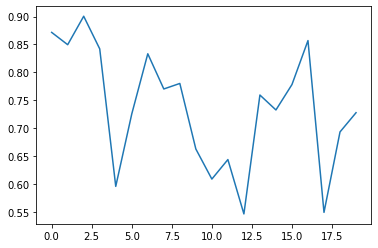

In [58]:
loss_epoch_arr = []
max_epochs = 20

min_loss = 1000

#n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs, aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 400 == 0:
            print('Iteration: %d, Loss: %0.2f' % (i,  loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
  
    
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
    epoch, max_epochs, 
    evaluation_inception(testloader, inception), 
    evaluation_inception(trainloader, inception)))

    
plt.plot(loss_epoch_arr)
plt.show()

## AlexNet

In [59]:
alex_net = model.alexnet(pretrained=True)
print(alex_net)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


In [60]:
for param in alex_net.parameters():
  param.requires_grad = False

  

In [61]:
in_features = alex_net.classifier[6].in_features
alex_net.classifier[6] = nn.Linear(in_features,2)

In [62]:
for param in alex_net.parameters():
  if(param.requires_grad ):
    print(param.size())

  

torch.Size([2, 4096])
torch.Size([2])


In [63]:
print(alex_net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [64]:
for param in alex_net.features[3:9].parameters():
  param.requires_grad = True


In [65]:
for param in alex_net.parameters():
  if (param.requires_grad ):
    print(param.size())

  

torch.Size([192, 64, 5, 5])
torch.Size([192])
torch.Size([384, 192, 3, 3])
torch.Size([384])
torch.Size([256, 384, 3, 3])
torch.Size([256])
torch.Size([2, 4096])
torch.Size([2])


In [66]:
def fit(epochs,loss_fn,opt,model):

  loss_arr = []
  n_iter = 400
  for epoch in range(epochs):
    
    for i,data in enumerate(trainloader):
      
      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)
      opt.zero_grad()
      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      loss = loss_fn(outputs,labels)
      loss.backward()
      opt.step()
      del inputs,labels,outputs
      torch.cuda.empty_cache()
      if(i % 100 == 0):
        print(f'Epoch:{epoch+1}: Iteration {i}/{n_iter}: Loss: {loss.item()}')
        
    loss_arr.append(loss.item())
    print(f'Epoch:{epoch}/{epochs}: The Train Accuracy: {evaluation(trainloader,model)} . The Test Accuracy: {evaluation(testloader,model)}')
      
  

  plt.plot(loss_arr)
  plt.show()

    
  

In [67]:
def evaluation(dataloader,model):

    total,correct = 0,0
    for data in dataloader:

      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)

      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      correct += (pred == labels).sum().item()
      total += labels.size(0)

    return 100*correct/total


Epoch:1: Iteration 0/400: Loss: 0.7233535051345825
Epoch:0/30: The Train Accuracy: 55.95903165735568 . The Test Accuracy: 52.030947775628626
Epoch:2: Iteration 0/400: Loss: 0.6425794959068298
Epoch:1/30: The Train Accuracy: 61.42147734326505 . The Test Accuracy: 58.89748549323017
Epoch:3: Iteration 0/400: Loss: 0.6722493171691895
Epoch:2/30: The Train Accuracy: 65.73556797020484 . The Test Accuracy: 69.24564796905223
Epoch:4: Iteration 0/400: Loss: 0.6189222931861877
Epoch:3/30: The Train Accuracy: 67.44258224705152 . The Test Accuracy: 71.08317214700193
Epoch:5: Iteration 0/400: Loss: 0.6398311853408813
Epoch:4/30: The Train Accuracy: 69.21166977032898 . The Test Accuracy: 73.30754352030948
Epoch:6: Iteration 0/400: Loss: 0.5794280767440796
Epoch:5/30: The Train Accuracy: 71.260086902545 . The Test Accuracy: 76.88588007736944
Epoch:7: Iteration 0/400: Loss: 0.6273934245109558
Epoch:6/30: The Train Accuracy: 71.72563625077592 . The Test Accuracy: 77.27272727272727
Epoch:8: Iteration 0/

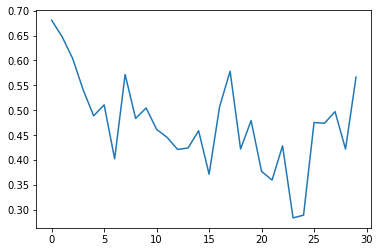

In [68]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=128,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=128,shuffle=False)

alex_net = alex_net.to(device)
#manual_weights = [0.5,5]
#manual_weights = torch.FloatTensor(manual_weights).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(alex_net.parameters(),lr = 0.00001)
fit(30,loss_fn,opt,alex_net)

In [71]:
def get_outputs(dataloader,model):
  
  y_pred = []
  y_true = []
  for data in dataloader:

    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    outputs = model(inputs)
    _,pred = torch.max(outputs.data,1)
    y_true.append(labels.squeeze().flatten().tolist())
    y_pred.append(pred.squeeze().flatten().tolist())

  return y_pred,y_true

In [72]:
y_pred,y_true = get_outputs(testloader,alex_net)

In [73]:
import itertools
y_pred = list(itertools.chain(*y_pred))
y_true = list(itertools.chain(*y_true))

In [74]:
print(len(y_pred),len(y_true))

1034 1034


In [75]:
from sklearn.metrics import classification_report

In [76]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true,y_pred))

[[444  73]
 [108 409]]


In [77]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       517
           1       0.85      0.79      0.82       517

    accuracy                           0.82      1034
   macro avg       0.83      0.82      0.82      1034
weighted avg       0.83      0.82      0.82      1034



## VGG

In [18]:
vgg = model.vgg16_bn(pretrained=True)
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 25

In [19]:
for param in vgg.parameters():
    param.requires_grad = False

In [20]:
for param in vgg.features[3:12].parameters():
  param.requires_grad = True

In [21]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, 2)

In [22]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([2, 4096])
torch.Size([2])


Epoch:1: Iteration 0/400: Loss: 0.7384395599365234
Epoch:1: Iteration 100/400: Loss: 0.584227979183197
Epoch:0/20: The Train Accuracy: 71.47734326505277 . The Test Accuracy: 52.41779497098646
Epoch:2: Iteration 0/400: Loss: 0.4999004304409027
Epoch:2: Iteration 100/400: Loss: 0.5149341821670532
Epoch:1/20: The Train Accuracy: 74.39478584729981 . The Test Accuracy: 52.61121856866538
Epoch:3: Iteration 0/400: Loss: 0.5314221382141113
Epoch:3: Iteration 100/400: Loss: 0.35916876792907715
Epoch:2/20: The Train Accuracy: 75.13966480446928 . The Test Accuracy: 58.80077369439071
Epoch:4: Iteration 0/400: Loss: 0.6711024641990662
Epoch:4: Iteration 100/400: Loss: 0.5081770420074463
Epoch:3/20: The Train Accuracy: 77.25015518311608 . The Test Accuracy: 55.89941972920696
Epoch:5: Iteration 0/400: Loss: 0.31638169288635254
Epoch:5: Iteration 100/400: Loss: 0.5729053020477295
Epoch:4/20: The Train Accuracy: 77.59155803848542 . The Test Accuracy: 52.030947775628626
Epoch:6: Iteration 0/400: Loss: 0

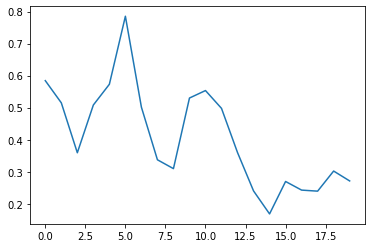

In [23]:
vgg = vgg.to(device)
#manual_weights = [0.5,3]
#manual_weights = torch.FloatTensor(manual_weights).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(vgg.parameters(), lr=0.0005)
fit(20,loss_fn,opt,vgg)

## ResNet-18

In [24]:
resnet = model.resnet18(pretrained=True)
print(resnet)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [25]:
for param in resnet.parameters():
    param.requires_grad = False

In [26]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, 2)

In [27]:
for param in resnet.layer1.parameters():
  param.requires_grad = True

In [28]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([2, 512])
torch.Size([2])


Epoch:1: Iteration 0/400: Loss: 0.6926454901695251
Epoch:1: Iteration 100/400: Loss: 0.6373963952064514
Epoch:0/20: The Train Accuracy: 58.845437616387336 . The Test Accuracy: 49.61315280464217
Epoch:2: Iteration 0/400: Loss: 0.6800181865692139
Epoch:2: Iteration 100/400: Loss: 0.6035987138748169
Epoch:1/20: The Train Accuracy: 63.159528243327124 . The Test Accuracy: 49.516441005802704
Epoch:3: Iteration 0/400: Loss: 0.739343523979187
Epoch:3: Iteration 100/400: Loss: 0.7074939608573914
Epoch:2/20: The Train Accuracy: 64.99068901303538 . The Test Accuracy: 49.806576402321085
Epoch:4: Iteration 0/400: Loss: 0.659716784954071
Epoch:4: Iteration 100/400: Loss: 0.6871592998504639
Epoch:3/20: The Train Accuracy: 66.94599627560521 . The Test Accuracy: 49.61315280464217
Epoch:5: Iteration 0/400: Loss: 0.753122091293335
Epoch:5: Iteration 100/400: Loss: 0.6757988929748535
Epoch:4/20: The Train Accuracy: 68.40471756672873 . The Test Accuracy: 50.0
Epoch:6: Iteration 0/400: Loss: 0.6122679710388

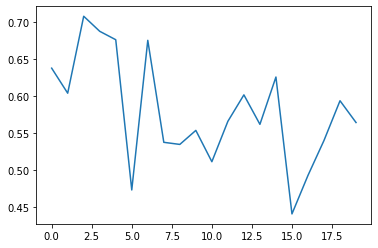

In [29]:
resnet = resnet.to(device)
#manual_weights = [0.5,3]
#manual_weights = torch.FloatTensor(manual_weights).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(resnet.parameters(), lr=0.00001)
fit(20,loss_fn,opt,resnet)

# MobileNet

In [ ]:
mobilenet = model.mobilenet_v2(pretrained = True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [ ]:
print(mobilenet)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
for param in mobilenet.parameters():
  param.requires_grad = False

  

In [ ]:
in_features = mobilenet.classifier[1].in_features
mobilenet.classifier[1] = nn.Linear(in_features,2)

In [ ]:
for param in mobilenet.parameters():
  if(param.requires_grad ):
    print(param.size())

  

torch.Size([2, 1280])
torch.Size([2])


In [ ]:
for param in mobilenet.features[0:2].parameters():
  param.requires_grad = True


In [ ]:
for param in mobilenet.parameters():
  if (param.requires_grad ):
    print(param.size())

  

torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([32])
torch.Size([16, 32, 1, 1])
torch.Size([16])
torch.Size([16])
torch.Size([2, 1280])
torch.Size([2])


In [ ]:
def fit(epochs,loss_fn,opt,model):

  loss_arr = []
  n_iter = 400
  for epoch in range(epochs):
    
    for i,data in enumerate(trainloader):
      
      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)
      opt.zero_grad()
      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      loss = loss_fn(outputs,labels)
      loss.backward()
      opt.step()
      del inputs,labels,outputs
      torch.cuda.empty_cache()
      if(i % 100 == 0):
        print(f'Epoch:{epoch+1}: Iteration {i}/{n_iter}: Loss: {loss.item()}')
        
    loss_arr.append(loss.item())
    print(f'Epoch:{epoch}/{epochs}: The Train Accuracy: {evaluation(trainloader,model)} . The Test Accuracy: {evaluation(testloader,model)}')
      
  

  plt.plot(loss_arr)
  plt.show()

    
  

In [ ]:
def evaluation(dataloader,model):

    total,correct = 0,0
    for data in dataloader:

      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)

      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      correct += (pred == labels).sum().item()
      total += labels.size(0)

    return 100*correct/total


Epoch:1: Iteration 0/400: Loss: 0.6298512816429138
Epoch:0/20: The Train Accuracy: 71.8187461204221 . The Test Accuracy: 51.644100580270795
Epoch:2: Iteration 0/400: Loss: 0.4405824840068817
Epoch:1/20: The Train Accuracy: 62.693978895096215 . The Test Accuracy: 46.03481624758221
Epoch:3: Iteration 0/400: Loss: 0.9484259486198425
Epoch:2/20: The Train Accuracy: 65.3941651148355 . The Test Accuracy: 52.61121856866538
Epoch:4: Iteration 0/400: Loss: 0.8267432451248169
Epoch:3/20: The Train Accuracy: 70.45313469894475 . The Test Accuracy: 49.32301740812379
Epoch:5: Iteration 0/400: Loss: 0.5140975713729858
Epoch:4/20: The Train Accuracy: 68.6219739292365 . The Test Accuracy: 55.029013539651835
Epoch:6: Iteration 0/400: Loss: 0.7517022490501404
Epoch:5/20: The Train Accuracy: 71.47734326505277 . The Test Accuracy: 47.195357833655706
Epoch:7: Iteration 0/400: Loss: 0.5704176425933838
Epoch:6/20: The Train Accuracy: 73.9292364990689 . The Test Accuracy: 52.51450676982592
Epoch:8: Iteration 0

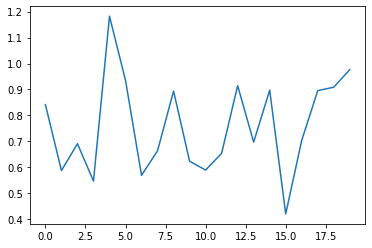

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=64,shuffle=False)

mobilenet = mobilenet.to(device)
#manual_weights = [0.5,5]
#manual_weights = torch.FloatTensor(manual_weights).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(mobilenet.parameters(),lr = 0.01)
fit(20,loss_fn,opt,mobilenet)

# AkaNet

In [ ]:
class AkaNet(nn.Module):
  
  def __init__(self):
    
    super(AkaNet,self).__init__()

    self.model_cnn = nn.Sequential(
        nn.Conv2d(3,6,3), #(N,1,224,224) --> (N,6,222,222)
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2), #(N,6,222,222) -->(N,6,111,111)
        nn.Conv2d(6,16,5), #(N,6,111,111)  --> (N,16,107,107)
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2), #(N,16,107,107) --> (N,16,53,53)
        
    )

    self.model_fc = nn.Sequential(
        nn.Dropout(),
        nn.Linear(44944,120),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(120,60),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(60,20),
        nn.ReLU(),
        nn.Linear(20,2) 
    )

  def forward(self,x):
    x = self.model_cnn(x)
    x = x.view(x.size(0),-1)
    x = self.model_fc(x)
    return x


In [ ]:
net = AkaNet()

In [ ]:
def evaluation(dataloader,model):

    total,correct = 0,0
    for data in dataloader:

      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)

      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      correct += (pred == labels).sum().item()
      total += labels.size(0)

    return 100*correct/total


In [ ]:
def fit(epochs,loss_fn,opt,model):

  loss_arr = []
  n_iter = 400
  for epoch in range(epochs):
    
    for i,data in enumerate(trainloader):
      
      inputs,labels = data
      inputs,labels = inputs.to(device),labels.to(device)
      opt.zero_grad()
      outputs = model(inputs)
      _,pred = torch.max(outputs.data,1)

      loss = loss_fn(outputs,labels)
      loss.backward()
      opt.step()
      del inputs,labels,outputs
      torch.cuda.empty_cache()
      if(i % 100 == 0):
        print(f'Epoch:{epoch+1}: Iteration {i}/{n_iter}: Loss: {loss.item()}')
        
    loss_arr.append(loss.item())
    print(f'Epoch:{epoch}/{epochs}: The Train Accuracy: {evaluation(trainloader,model)} . The Test Accuracy: {evaluation(testloader,model)}')
      
  

  plt.plot(loss_arr)
  plt.show()

    
  

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
trainset = torchvision.datasets.ImageFolder('./data/SocoFing_data(alter_real_and_gender_train_test)/finger_gender_data_train',transform=transform)
testset = torchvision.datasets.ImageFolder('./data/SocoFing_data(alter_real_and_gender_train_test)/finger_gender_data_test',transform = transform)

In [ ]:
trainset.class_to_idx

{'female': 0, 'male': 1}

In [ ]:
testset.class_to_idx

{'female': 0, 'male': 1}

In [ ]:
net = AkaNet()


Epoch:1: Iteration 0/400: Loss: 0.7023357152938843
Epoch:0/20: The Train Accuracy: 68.1253879577902 . The Test Accuracy: 68.27852998065764
Epoch:2: Iteration 0/400: Loss: 0.5838258862495422
Epoch:1/20: The Train Accuracy: 67.47361887026692 . The Test Accuracy: 67.50483558994198
Epoch:3: Iteration 0/400: Loss: 0.601347029209137
Epoch:2/20: The Train Accuracy: 67.5356921166977 . The Test Accuracy: 67.79497098646034
Epoch:4: Iteration 0/400: Loss: 0.5997406840324402
Epoch:3/20: The Train Accuracy: 68.06331471135941 . The Test Accuracy: 68.56866537717602
Epoch:5: Iteration 0/400: Loss: 0.6303588151931763
Epoch:4/20: The Train Accuracy: 67.87709497206704 . The Test Accuracy: 67.8916827852998
Epoch:6: Iteration 0/400: Loss: 0.6616268157958984
Epoch:5/20: The Train Accuracy: 69.24270639354438 . The Test Accuracy: 68.56866537717602
Epoch:7: Iteration 0/400: Loss: 0.5995336771011353
Epoch:6/20: The Train Accuracy: 70.60831781502172 . The Test Accuracy: 67.69825918762089
Epoch:8: Iteration 0/400

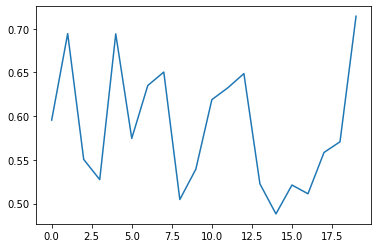

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=128,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=128,shuffle=False)

net = net.to(device)
#manual_weights = [0.5,5]
#manual_weights = torch.FloatTensor(manual_weights).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(),lr=0.0001,betas=(0.7,0.9))
fit(20,loss_fn,opt,net)